# Machine Learning

* Working through Machine Learning for Physics and Astronomy (Aquaviva)
  * can't locate notebooks to accompany the book 

# Chapter 1: Introduction

## Definitions
* **feature** - property, like stellar mass, local density, etc
* **output** - what you want to try to infer

## Supervised learning
You know what the desired output is, and how to determine the output for some subset of data.
* training set - made from data
* test set - subset of a the original training set that you will use to see how well the model works
* rate of failure - *error*
* rate of success - *score*
* classification will produce a discrete output
  * used when there is a lack of continuity between classes, like image id to separate dogs from cats
* regression will provide continuous values for output
* difference between classification and regression is the output - the features can be the same/similar

## Unsupervised Learning
Looking for a pattern in the data
* clustering is an example of unsupervised learning
* dimensionality reduction is another example - determine which features are correlated, and reduce input to features that are independent

## Inference vs machine learning
* inference will explicitly specify what the output should be given a set of input parameters.  this can be used when you have some physical foundation that determines the relationship between input and output variables.
* basis for relationship between input and output variables can be less clear with machine learning.

## Example: Fitting a straight line with inference and ML

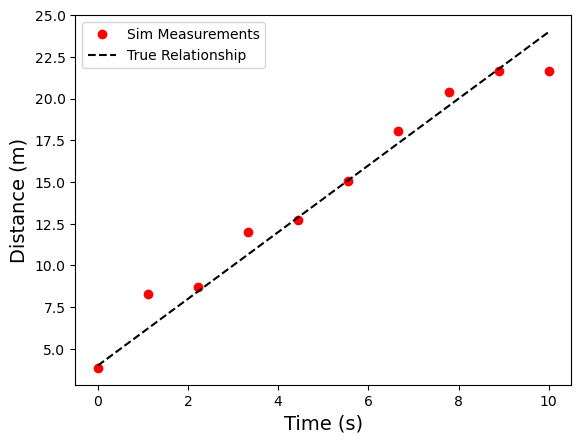

In [45]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 14

# set the seed value for repeatability
np.random.seed(99)


# make up data
y0 = 4.
slope = 2.0


x = np.linspace(0,10,10)

# create data with gaussian noise to simulation measurement error
yerr = 1.
y = y0 + slope*x + np.random.normal(loc=0,scale=yerr, size=len(x))

# plot sim data
plt.figure()
plt.plot(x,y,'ro', label="Sim Measurements")

plt.plot(x, y0+slope*x, 'k--', label="True Relationship")

plt.xlabel("Time (s)")#,fontsize=16)
plt.ylabel("Distance (m)")#,fontsize=16)
plt.legend()

In [61]:
# Using polyfit for comparison

c = np.polyfit(x,y,1)

print(f"polyfit best-fit slope = {c[0]:.2f}, intercept = {c[1]:.2f}")

polyfit best-fit slope = 1.81, intercept = 5.17


In [65]:
# going to do brute force search for best slope and intercept

# set up possible values for slope and intercept
slopes = np.linspace(1, 3, 101)
intercepts = np.linspace(4, 6, 101)

def model(x, m, b):
    """ model is a straight line to represent dist vs time for uniform motion """
    return m*x + b


def se(m, b, x, y):
    """ error is the sum of the sq distance between model and measured vals """
    return np.sum((model(x,m,b) - y)**2)

# basically doing a double loop here - could be clearer for intro students
square_errs = np.array([[se(m,b,x,y) for b in intercepts] for m in slopes])
print(square_errs.shape)

# need to unpack this

indices = np.unravel_index(square_errs.argmin(), square_errs.shape)
print(square_errs.argmin())
print("indices = ", indices)


# why are we using indices[1] for the intercepts?  should be same for both?
bestm, bestb = slopes[indices[0]], intercepts[indices[1]]

print(f"best-fit slope = {bestm:.2f}, intercept = {bestb:.2f}")

(101, 101)
4198
indices =  (41, 57)
best-fit slope = 1.82, intercept = 5.14


### Now with machine learning...

In [47]:
from sklearn.model_selection import train_test_split

np.random.seed(10)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=3)

In [48]:
from sklearn.tree import DecisionTreeRegressor
treemodel = DecisionTreeRegressor()

treefit = treemodel.fit(X_train.reshape(-1,1), Y_train)

y_pred_tree = treemodel.predict(X_test.reshape(-1,1))

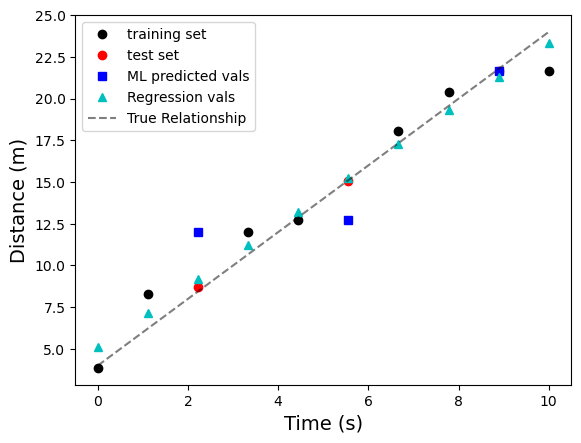

In [56]:
# plot results

plt.figure()
plt.plot(X_train, Y_train, 'ko', label="training set")
plt.plot(X_test, Y_test,'ro', label="test set")
plt.plot(X_test, y_pred_tree,'bs', label="ML predicted vals")


plt.plot(x, bestb+bestm*x, 'c^', label="Regression vals")
plt.plot(x, y0+slope*x, 'k--', label="True Relationship", alpha=0.5)

plt.xlabel("Time (s)")#,fontsize=16)
plt.ylabel("Distance (m)")#,fontsize=16)
plt.legend()

In [43]:
print(X_train)
print(X_train.reshape(-1,1))
print(X_train.T)

[ 6.66666667  3.33333333  1.11111111  0.          7.77777778  4.44444444
 10.        ]
[[ 6.66666667]
 [ 3.33333333]
 [ 1.11111111]
 [ 0.        ]
 [ 7.77777778]
 [ 4.44444444]
 [10.        ]]
[ 6.66666667  3.33333333  1.11111111  0.          7.77777778  4.44444444
 10.        ]


# Chapter 2

### Habitability

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# from notebooks that accompany the textbook
from sklearn.tree import DecisionTreeClassifier #how methods are imported 

from sklearn import metrics #this will give us access to evaluation metrics

In [67]:
# read in data
filename = '/Users/rfinn/github/ML_learning/MLPA_notebooks/CH 2 Notebooks/HPLearningSet.csv'
LearningSet = pd.read_csv(filename)

In [68]:
LearningSet

,Unnamed: 0,P_NAME,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
0,0,Kepler-736 b,0.86,3.601472,0.043718,0
1,1,Kepler-636 b,0.85,16.080661,0.118082,0
2,2,Kepler-887 c,1.19,7.638460,0.080420,0
3,3,Kepler-442 b,0.61,112.305300,0.409327,1
4,4,Kepler-772 b,0.98,12.992073,0.107408,0
5,5,Teegarden's Star b,0.09,4.910000,0.025200,1
6,6,K2-116 b,0.69,4.655411,0.048086,0
7,7,GJ 1061 c,0.12,6.689000,0.035000,1
8,8,HD 68402 b,1.12,1103.000000,2.180981,0
9,9,Kepler-1544 b,0.81,168.811170,0.557107,1


In [71]:
# split into training and learning set

# save first 13 into training set
TrainSet = LearningSet.iloc[:13,:]


TestSet = LearningSet.iloc[13:,:]

# get independent and dependent variables

Xtrain = TrainSet.drop(['P_NAME','P_HABITABLE'], axis = 1)
Xtest = TestSet.drop(['P_NAME','P_HABITABLE'], axis = 1)

ytrain = TrainSet.P_HABITABLE
ytest = TestSet.P_HABITABLE

In [72]:
# set up model

model = DecisionTreeClassifier(random_state = 3)

model.fit(Xtrain, ytrain)

DecisionTreeClassifier(random_state=3)

In [76]:
# predictions from model

ypred = model.predict(Xtest)
print('accuracy score: ',metrics.accuracy_score(ytest, ypred))

print(ypred)
print(ytest)

accuracy score:  0.6
[1 1 1 0 1]
13    0
14    0
15    1
16    0
17    1
Name: P_HABITABLE, dtype: int64


In [77]:
help(model)

Help on DecisionTreeClassifier in module sklearn.tree._classes object:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0, monotonic_cst=None)
 |
 |  A decision tree classifier.
 |
 |  Read more in the :ref:`User Guide <tree>`.
 |
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy", "log_loss"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "log_loss" and "entropy" both for the
 |      Shannon information gain, see :ref:`tree_mathematical_formulation`.
 |
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies a

# Chapter 3

# Chapter 4

# Chapter 5

# Chapter 6

# Chapter 7

# Chapter 8